In [ ]:
!nvidia-smi

Tue Apr 13 01:28:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install --pre torch torchvision torchaudio torchtext -f https://download.pytorch.org/whl/nightly/cu102/torch_nightly.html -U
!pip install SpecAugment
!pip install librosa tensorboardX wandb -U

Looking in links: https://download.pytorch.org/whl/nightly/cu102/torch_nightly.html
     |████████████████████████████████| 825.0MB 17kB/s 
     |████████████████████████████████| 18.2MB 103.9MB/s 
     |████████████████████████████████| 1.9MB 54.8MB/s 
     |████████████████████████████████| 7.2MB 444kB/s 
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: torchtext 0.9.1
    Uninstalling torchtext-0.9.1:
      Successfully uninstalled torchtext-0.9.1
Requirement already up-to-date: librosa in /usr/local/lib/python3.7/dist-packages (0.8.0)
     |████████████████████████████████| 122kB 9.1MB/s 
     |████████████████████████████████| 2.1MB 13.7MB/s 
     |████████████████████████████████| 163kB 48.6MB/s 
     |██████████████

In [ ]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchaudio
import numpy as np
import wandb
from torch.utils.data import DataLoader, Dataset
from itertools import cycle, islice
import librosa
import pandas as pd
from PIL import Image
from tqdm import tqdm
import os
import shutil
from tensorboardX import SummaryWriter

In [ ]:
!sudo apt-get install pigz axel

from google.colab import drive
drive.mount('/content/drive')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  axel pigz
0 upgraded, 2 newly installed, 0 to remove and 31 not upgraded.
Need to get 114 kB of archives.
After this operation, 440 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 pigz amd64 2.4-1 [57.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 axel amd64 2.16.1-1build1 [56.1 kB]
Fetched 114 kB in 1s (135 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previo

In [ ]:
!pigz -dc drive/My\ Drive/UrbanSound8K.tar.gz | tar xf - -C ./
# alternatively, download the dataset from this HTTP url:
# !wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
# and extract:
# !tar -xf ./UrbanSound8K.tar.gz

In [ ]:
params = {
	"dataset_name": "UrbanSound8K",
	"data_dir": "./UrbanSound8K",

  "n_fft": 2205,
  "window_sizes": [25, 50, 100],
  "hop_sizes": [10, 25, 50],
  "n_mels": 128,

	"dataaug": False,
	"pretrained": True,
	"scheduler": True,
	"architecture": "MobileNetV3",
	"batch_size": 64,
	"num_workers": 8,
	"epochs": 140,
	"lr": 1e-4,
  "weight_decay": 1e-3,
  "val_fold": 10,
  "checkpoint_dir": "./"
}

In [ ]:
#df = pd.read_csv(f"{params['data_dir']}/metadata/UrbanSound8K.csv")
!wget http://76.213.149.126:8081/UrbanSound8K/metadata/UrbanSound8K.csv
df = pd.read_csv("./UrbanSound8K.csv")
df

--2021-04-13 01:28:38--  http://76.213.149.126:8081/UrbanSound8K/metadata/UrbanSound8K.csv
Connecting to 76.213.149.126:8081... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494104 (483K) [text/csv]
Saving to: ‘UrbanSound8K.csv.1’

UrbanSound8K.csv.1  100%[===================>] 482.52K  1.34MB/s    in 0.4s    

2021-04-13 01:28:38 (1.34 MB/s) - ‘UrbanSound8K.csv.1’ saved [494104/494104]



,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# contain dataset for both train and validation sets for easier
# loading and changing folds. Changing folds for validation won't
# require the data to be modified since everything is stored together.
shared_data_memory = {}

import pickle
for x in range(0, 9):
  with open(f"/content/drive/MyDrive/UrbanSound8K_extracted_{x}.pkl", "rb") as rb:
    stored_dict = pickle.load(rb)
    for a in stored_dict:
      shared_data_memory[a] = stored_dict[a].copy()
    del stored_dict
    print(f"Finished loading UrbanSound8K_extracted_{x}.pkl")

print(len(shared_data_memory))

Finished loading UrbanSound8K_extracted_0.pkl
Finished loading UrbanSound8K_extracted_1.pkl
Finished loading UrbanSound8K_extracted_2.pkl
Finished loading UrbanSound8K_extracted_3.pkl
Finished loading UrbanSound8K_extracted_4.pkl
Finished loading UrbanSound8K_extracted_5.pkl
Finished loading UrbanSound8K_extracted_6.pkl
Finished loading UrbanSound8K_extracted_7.pkl
Finished loading UrbanSound8K_extracted_8.pkl
8732


In [ ]:
#shared_data_memory = {}

class UrbanSoundDataset(Dataset):
    # wrapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csv_path, file_path, folderList):
        csvData = pd.read_csv(csv_path)
        #initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []
        self.folders = []
        #loop through the csv entries and only add entries from folders in the folder list
        for i in range(0,len(csvData)):
            if csvData.iloc[i, 5] in folderList:
                self.file_names.append(csvData.iloc[i, 0])
                self.labels.append(csvData.iloc[i, 6])
                self.folders.append(csvData.iloc[i, 5])
                
        self.file_path = file_path
        #self.mixer = torchaudio.transforms.DownmixMono() # Convert stereo audio to mono
        self.folderList = folderList
        self.num_channels = 3
        self.window_sizes = params["window_sizes"]
        self.hop_sizes =  params["hop_sizes"]
        self.data_memory = shared_data_memory
        self.normalize = torchvision.transforms.Normalize(mean=[-2.0064, -1.2480, -0.4483], std=[3.9764, 3.9608, 3.9427], inplace=False)

    def __getitem__(self, index):
        # see https://github.com/pytorch/audio/issues/80 for torchaudio vs librosa

        # format the file path and load the file
        path = self.file_path + "fold" + str(self.folders[index]) + "/" + self.file_names[index]
        if path in self.data_memory:
          return self.normalize.forward(self.data_memory[path]["spec"]), self.data_memory[path]["label"]
          # return (self.data_memory[path]["spec"]), self.data_memory[path]["label"]

        else:
          sound, sr = torchaudio.load(path)
          soundData = torch.mean(sound, dim=0, keepdim=True)
          # downsample the audio to 22.5khz
          soundData = torchaudio.transforms.Resample(sr, 22050).forward(soundData)
          # pad to 4 seconds
          # Ommited for now to reproduce a paper

          num_channels = 3
          window_sizes = params["window_sizes"]
          hop_sizes = params["hop_sizes"]
          spec = self.extract_spectrogram(soundData, 22050)
          #spec -= spec.min()
          #spec /= spec.max()
          # spec = self.normalize(spec)
          self.data_memory[path] = {}
          self.data_memory[path]["spec"] = spec
          self.data_memory[path]["label"] = self.labels[index]

          return spec, self.labels[index]
    
    def __len__(self):
        return len(self.file_names)

    def extract_spectrogram(self, waveform, sr):
      specs = []
      for i in range(self.num_channels):
          window_length = int(round(self.window_sizes[i]*sr/1000))
          hop_length = int(round(self.hop_sizes[i]*sr/1000))

          spec = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=params["n_fft"], win_length=window_length, hop_length=hop_length, n_mels=params["n_mels"])(waveform)
          eps = 1e-6
          spec = torch.log(spec + eps)
          spec = torchvision.transforms.Resize((128, 250))(spec)
          specs.append(torch.squeeze(spec))
      return torch.stack(specs)
        
#csv_path = f'{params["data_dir"]}/metadata/UrbanSound8K.csv'
csv_path = './UrbanSound8K.csv'

file_path = f'{params["data_dir"]}/audio/'

train_folds = list(range(1, 11))
train_folds.remove(params["val_fold"])
train_set = UrbanSoundDataset(csv_path, file_path, train_folds)
test_set = UrbanSoundDataset(csv_path, file_path, [params["val_fold"]])
print("Train set size: " + str(len(train_set)))
print("Test set size: " + str(len(test_set)))

kwargs = {'num_workers': params["num_workers"], 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu

train_loader = torch.utils.data.DataLoader(train_set, batch_size = params["batch_size"], shuffle = True, **kwargs)
val_loader = torch.utils.data.DataLoader(test_set, batch_size = params["batch_size"], shuffle = True, **kwargs)

Train set size: 7895
Test set size: 837


In [ ]:
i = iter(train_loader)
print(i.next()[0].mean())

tensor(0.0712)


In [ ]:
# Calculate mean and std of dataset
j = []

for x in shared_data_memory:
  j.append(shared_data_memory[x]['spec'][2])

print(torch.stack(j).mean())
print(torch.stack(j).std())

tensor(-0.4483)
tensor(3.9427)


tensor(-1.8475)
torch.Size([3, 128, 250])


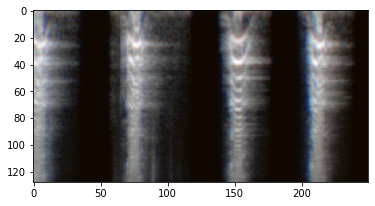

In [ ]:
import matplotlib.pyplot as plt

t = next(i)[0][0]

print(t.mean())
t = (t - t.min()) * 255 / (t.max() - t.min())
t = t.squeeze()
t = t.type(torch.IntTensor)
print(t.size())
plt.imshow(t.permute(1, 2, 0))

In [ ]:
import torchvision.models as models

class MobileNetV3(nn.Module):
  def __init__(self):
    super(MobileNetV3, self).__init__()
    num_classes = 10
    self.model = models.mobilenet_v3_large(pretrained=params["pretrained"])
    self.model.classifier[3] = nn.Linear(in_features= 1280, out_features= 10)
		
  def forward(self, x):
    output = self.model(x)
    return output

In [ ]:
class RunningAverage():
	def __init__(self):
		self.total = 0
		self.steps = 0
	def update(self, loss):
		self.total += loss
		self.steps += 1
	def __call__(self):
		return (self.total/float(self.steps))

def save_checkpoint(state, is_best, split, checkpoint):
  filename = os.path.join(checkpoint, 'last{}.pth.tar'.format(split))
  if not os.path.exists(checkpoint):
    print("Checkpoint Directory does not exist")
    os.mkdir(checkpoint)
  torch.save(state, filename)
  if is_best:
    shutil.copyfile(filename, os.path.join(checkpoint, "model_best_{}.pth.tar".format(split)))

def train(model, device, data_loader, optimizer, loss_fn, epoch=1):
    model.train()
    loss_avg = RunningAverage()

    with tqdm(total=len(data_loader)) as t:
        for batch_idx, data in enumerate(data_loader):
            inputs = data[0].to(device)
            target = data[1].to(device)

            outputs = model(inputs)

            loss = loss_fn(outputs, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg.update(loss.item())
            wandb.log({"avg_loss": loss_avg(), "batch": batch_idx})
            wandb.log({"batch_loss": loss.item(), "batch": batch_idx})

            t.set_postfix(loss='{:05.3f}'.format(loss_avg()))
            t.update()
    return loss_avg()

def evaluate(model, device, test_loader):
  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
    for batch_idx, data in enumerate(test_loader):
      inputs = data[0].to(device)
      target = data[1].to(device)

      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()

  return (100*correct/total)

def train_and_evaluate(model, device, train_loader, val_loader, optimizer, loss_fn, writer, params, split, scheduler=None):
    best_acc = 0.0

    for epoch in range(params["epochs"]):
        avg_loss = train(model, device, train_loader, optimizer, loss_fn, epoch=epoch)

        acc = evaluate(model, device, val_loader)
        print("Epoch {}/{} Loss:{} Valid Acc:{}".format(epoch, params["epochs"], avg_loss, acc))
        wandb.log({"epoch_avg_loss": avg_loss, 'epoch': epoch})
        wandb.log({"epoch_val_acc": acc, 'epoch': epoch})

        is_best = (acc > best_acc)
        if is_best:
            best_acc = acc
        if scheduler:
            scheduler.step()

        save_checkpoint({"epoch": epoch + 1,
                               "model": model.state_dict(),
                               "optimizer": optimizer.state_dict()}, is_best, split, "{}".format(params["checkpoint_dir"]))
        writer.add_scalar("data{}/trainingLoss{}".format(params["dataset_name"], split), avg_loss, epoch)
        writer.add_scalar("data{}/valLoss{}".format(params["dataset_name"], split), acc, epoch)
    writer.close()

model = MobileNetV3().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
writer = SummaryWriter(comment="US8K")
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 15, gamma=0.5)

In [ ]:
wandb.init(project="audio-classification", config = params)
wandb.watch(model, log_freq = len(train_loader))

avg_loss,0.28326
batch,112
_runtime,369
_timestamp,1618278226
_step,475
batch_loss,0.29925
epoch_avg_loss,0.97443
epoch,0
epoch_val_acc,53.88292


avg_loss,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇
_runtime,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇███████████████████
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇███████████████████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch_loss,█▇▇▆▅▄▄▄▃▃▃▂▃▃▃▂▂▂▃▂▂▂▁▂▂▁▁▂▁▁▁▁▁▂▂▁▁▂▁▁
epoch_avg_loss,▁
epoch,▁▁
epoch_val_acc,▁


In [ ]:
train_and_evaluate(model, device, train_loader, val_loader, optimizer, loss_fn, writer, params, 1, scheduler)

  0%|          | 0/124 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:938: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 124/124 [00:19<00:00,  6.43it/s, loss=0.971]


Epoch 0/140 Loss:0.9706459468410861 Valid Acc:57.22819593787336


100%|██████████| 124/124 [00:20<00:00,  6.03it/s, loss=0.270]


Epoch 1/140 Loss:0.2696284561027442 Valid Acc:77.41935483870968


100%|██████████| 124/124 [00:20<00:00,  5.94it/s, loss=0.124]


Epoch 2/140 Loss:0.1243529616584701 Valid Acc:80.28673835125448


100%|██████████| 124/124 [00:19<00:00,  6.30it/s, loss=0.064]


Epoch 3/140 Loss:0.06441326117924144 Valid Acc:83.99044205495818


 77%|███████▋  | 95/124 [00:15<00:04,  6.27it/s, loss=0.041]


KeyboardInterrupt: ignored

In [ ]:
import pickle

with open('./UrbanSound8K_extracted.pkl', 'wb') as wb:
  pickle.dump(shared_data_memory, wb)

In [ ]:
train(model, device, train_loader, optimizer, loss_fn)

  0%|          | 0/124 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)
100%|██████████| 124/124 [11:17<00:00,  5.47s/it, loss=0.539]


0.5392406314250923

In [ ]:
!ls -alh

total 3.7G
drwxr-xr-x 1 root       root       4.0K Jan 31 21:43 .
drwxr-xr-x 1 root       root       4.0K Jan 31 21:09 ..
drwxr-xr-x 1 root       root       4.0K Jan 28 17:15 .config
drwx------ 6 root       root       4.0K Jan 31 21:16 drive
-rw-r--r-- 1 root       root       270M Jan 31 21:39 last1.pth.tar
-rw-r--r-- 1 root       root       270M Jan 31 21:39 model_best_1.pth.tar
drwxr-xr-x 3 root       root       4.0K Jan 31 21:23 runs
drwxr-xr-x 1 root       root       4.0K Jan 20 17:27 sample_data
drwx--x--x 4 1829600028 1829600028 4.0K Jun  3  2014 UrbanSound8K
-rw-r--r-- 1 root       root       367M Jan 31 21:42 UrbanSound8K_extracted_0.pkl
-rw-r--r-- 1 root       root       367M Jan 31 21:42 UrbanSound8K_extracted_1.pkl
-rw-r--r-- 1 root       root       367M Jan 31 21:42 UrbanSound8K_extracted_2.pkl
-rw-r--r-- 1 root       root       367M Jan 31 21:42 UrbanSound8K_extracted_3.pkl
-rw-r--r-- 1 root       root       367M Jan 31 21:42 UrbanSound8K_extracted_4.pkl
-rw-r--r-- 1 root 

In [ ]:
a = [list(shared_data_memory.keys())[i:i + 1000] for i in range(0, len(shared_data_memory.keys()), 1000)]

In [ ]:
i = 0
import pickle

for x in a:
  new_dict = {}
  for b in x:
    new_dict[b] = shared_data_memory[b].copy()
  with open(f'./UrbanSound8K_extracted_{i}_2.pkl', 'wb') as wb:
    pickle.dump(new_dict, wb, protocol=pickle.HIGHEST_PROTOCOL)
  i += 1

In [ ]:
#!rm -rf *.pkl
#!ls drive/MyDrive/UrbanSound8K_extracted*

drive/MyDrive/UrbanSound8K_extracted_0_64.pkl
drive/MyDrive/UrbanSound8K_extracted_0.pkl
drive/MyDrive/UrbanSound8K_extracted_1_64.pkl
drive/MyDrive/UrbanSound8K_extracted_1.pkl
drive/MyDrive/UrbanSound8K_extracted_2_64.pkl
drive/MyDrive/UrbanSound8K_extracted_2.pkl
drive/MyDrive/UrbanSound8K_extracted_3_64.pkl
drive/MyDrive/UrbanSound8K_extracted_3.pkl
drive/MyDrive/UrbanSound8K_extracted_4_64.pkl
drive/MyDrive/UrbanSound8K_extracted_4.pkl
drive/MyDrive/UrbanSound8K_extracted_5_64.pkl
drive/MyDrive/UrbanSound8K_extracted_5.pkl
drive/MyDrive/UrbanSound8K_extracted_6_64.pkl
drive/MyDrive/UrbanSound8K_extracted_6.pkl
drive/MyDrive/UrbanSound8K_extracted_7_64.pkl
drive/MyDrive/UrbanSound8K_extracted_7.pkl
drive/MyDrive/UrbanSound8K_extracted_8_64.pkl
drive/MyDrive/UrbanSound8K_extracted_8.pkl


In [ ]:
model(torch.unsqueeze(normalize.forward(shared_data_memory['./UrbanSound8K/audio/fold9/149929-9-0-2.wav']['spec']), dim=0).to(device))

tensor([[-1.9556, -2.1128,  1.7430, -1.8726, -1.6952, -2.6460, -4.4745, -1.5207,
         -1.4191,  7.8923]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
!cp *.pkl /content/drive/MyDrive/

In [ ]:
!rm /content/drive/MyDrive/UrbanSound8K_extracted*

In [ ]:
for batch_idx, data in enumerate(train_loader):
  print(data[0].size())

torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size([64, 3, 128, 250])
torch.Size

KeyboardInterrupt: ignored

In [ ]:
import torch.onnx
x = torch.randn(1, 3, 128, 250, requires_grad=True).to(device)
print(model(x))

torch.onnx.export(model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "super_resolution.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

tensor([[-0.9283, -1.5445, -0.6775, -0.7921, -0.4560, -1.0093, -1.4347, -1.2389,
         -0.9882, -0.9128]], device='cuda:0', grad_fn=<AddmmBackward>)


In [ ]:
!ls -alh

total 116M
drwxr-xr-x 1 root root 4.0K Apr  9 18:14 .
drwxr-xr-x 1 root root 4.0K Apr  9 14:29 ..
drwxr-xr-x 4 root root 4.0K Apr  7 13:35 .config
drwx------ 6 root root 4.0K Apr  9 14:30 drive
-rw-r--r-- 1 root root  49M Apr  9 18:13 last1.pth.tar
-rw-r--r-- 1 root root  49M Apr  9 17:46 model_best_1.pth.tar
drwxr-xr-x 7 root root 4.0K Apr  9 17:34 runs
drwxr-xr-x 1 root root 4.0K Apr  7 13:36 sample_data
-rw-r--r-- 1 root root  17M Apr  9 18:14 super_resolution.onnx
-rw-r--r-- 1 root root 483K May 19  2014 UrbanSound8K.csv
-rw-r--r-- 1 root root 483K May 19  2014 UrbanSound8K.csv.1
-rw-r--r-- 1 root root 483K May 19  2014 UrbanSound8K.csv.2
-rw-r--r-- 1 root root 483K May 19  2014 UrbanSound8K.csv.3
drwxr-xr-x 7 root root 4.0K Apr  9 17:35 wandb


In [ ]:
!mv model.pt drive/MyDrive/

In [ ]:
shared_data_memory['./UrbanSound8K/audio/fold9/149929-9-0-2.wav']

{'label': 9,
 'spec': tensor([[[-2.2576, -4.7268, -4.6853,  ..., -4.6221, -4.6183, -3.8678],
          [-1.9157, -4.8300, -5.2970,  ..., -4.9196, -4.9905, -3.5854],
          [-1.8647, -5.4348, -6.4808,  ..., -5.4308, -5.6956, -4.0231],
          ...,
          [-4.6226, -7.9833, -7.6487,  ..., -7.7005, -7.8430, -7.4103],
          [-4.7252, -7.8518, -7.9511,  ..., -8.4815, -8.5042, -8.3906],
          [-4.5816, -7.9194, -7.2236,  ..., -8.0590, -8.0866, -7.9143]],
 
         [[-1.1281, -2.4155, -3.8900,  ..., -3.9064, -1.8066,  0.0242],
          [-0.6923, -3.0529, -5.7414,  ..., -5.8332, -2.5304,  0.3628],
          [-0.6002, -4.4367, -8.6957,  ..., -7.2967, -3.1604,  0.4004],
          ...,
          [-3.5134, -5.3061, -7.2529,  ..., -7.0350, -6.8270, -6.6018],
          [-3.5043, -5.2575, -7.2195,  ..., -7.7623, -7.1514, -6.5299],
          [-3.3256, -5.0261, -6.9392,  ..., -7.4202, -7.0024, -6.6535]],
 
         [[-0.9659, -0.9659, -1.8760,  ..., -1.1270,  0.1191,  0.1191],
       

In [ ]:
print(model(x))

tensor([[-1.1412, -1.4107, -0.3721, -0.8889, -0.4526, -0.9054, -1.6897, -1.1904,
         -1.0756, -0.8461]], device='cuda:0', grad_fn=<AddmmBackward>)


In [ ]:
#torch.save(model, "model.pt")
torch.save(model.state_dict(), "drive/MyDrive/model_2.pt")
#!rm -rf "drive/MyDrive/model_2.pt"

In [ ]:
from IPython.display import Audio

!wget http://76.213.149.126:8081/UrbanSound8K/audio/fold8/113202-5-0-19.wav -O engine_idling_test.wav
!wget http://76.213.149.126:8081/UrbanSound8K/audio/fold9/149929-9-0-2.wav -O street_music_test.wav

print("Downloaded test file for engine idling")
Audio("engine_idling_test.wav")

print("Downloaded test file for street music")
Audio("street_music_test.wav")

--2021-04-13 01:09:50--  http://76.213.149.126:8081/UrbanSound8K/audio/fold8/113202-5-0-19.wav
Connecting to 76.213.149.126:8081... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2304080 (2.2M) [audio/x-wav]
Saving to: ‘engine_idling_test.wav’

engine_idling_test. 100%[===================>]   2.20M  2.61MB/s    in 0.8s    

2021-04-13 01:09:51 (2.61 MB/s) - ‘engine_idling_test.wav’ saved [2304080/2304080]

--2021-04-13 01:09:51--  http://76.213.149.126:8081/UrbanSound8K/audio/fold9/149929-9-0-2.wav
Connecting to 76.213.149.126:8081... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1058480 (1.0M) [audio/x-wav]
Saving to: ‘street_music_test.wav’

street_music_test.w 100%[===================>]   1.01M  1.46MB/s    in 0.7s    

2021-04-13 01:09:52 (1.46 MB/s) - ‘street_music_test.wav’ saved [1058480/1058480]

Downloaded test file for engine idling
Downloaded test file for street music


In [ ]:
path = "engine_idling_test.wav"
#path = "street_music_test.wav"

sound, sr = torchaudio.load(path) #, out = None, normalization = True)
soundData = torch.mean(sound, dim=0, keepdim=True)
# downsample the audio to 22.5khz
soundData = torchaudio.transforms.Resample(sr, 22050).forward(soundData)
# pad to 4 seconds
# Ommited for now to reproduce a paper

normalize = torchvision.transforms.Normalize(mean=[-2.0064, -1.2480, -0.4483], std=[3.9764, 3.9608, 3.9427], inplace=False)

num_channels = 3

specs = []
for i in range(3): # we have 3 channels
  sr = 22050
  window_length = int(round(([25, 50, 100][i])*sr/1000))
  hop_length = int(round(([10, 25, 50][i])*sr/1000))

  spec = torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_fft=2205, win_length=window_length, hop_length=hop_length, n_mels=128)(soundData)
  eps = 1e-6
  spec = torch.log(spec + eps)
  spec = torchvision.transforms.Resize((128, 250))(spec)
  specs.append(torch.squeeze(spec))
spec = torch.stack(specs)

#spec -= spec.min()
#spec /= spec.max()

spec = normalize.forward(spec)

spec = spec.unsqueeze(0)
print(spec)

tensor([[[[ 0.8993,  1.3304,  1.1785,  ...,  1.5610,  1.3153,  1.4268],
          [ 0.8781,  1.5001,  1.3912,  ...,  1.6043,  1.5572,  1.5046],
          [ 0.7019,  1.5625,  1.3988,  ...,  1.5637,  1.6149,  1.4848],
          ...,
          [-0.8161, -1.2362, -1.3554,  ..., -1.2281, -1.2393, -1.2155],
          [-1.0113, -1.2323, -1.3053,  ..., -1.3612, -1.1705, -1.2444],
          [-0.7962, -1.1545, -1.4169,  ..., -1.4244, -1.3846, -1.2584]],

         [[ 0.7127,  0.8750,  1.0771,  ...,  1.3010,  1.1248,  0.9736],
          [ 1.2410,  1.3673,  1.5182,  ...,  1.6449,  1.4999,  1.3769],
          [ 1.2398,  1.3915,  1.5568,  ...,  1.6342,  1.6505,  1.6712],
          ...,
          [-0.8109, -1.0569, -1.3286,  ..., -1.2522, -1.0278, -0.8375],
          [-1.0077, -1.1154, -1.2397,  ..., -1.2200, -0.9971, -0.8132],
          [-0.7510, -0.9714, -1.2428,  ..., -1.3794, -1.0789, -0.8115]],

         [[ 0.7413,  0.7413,  0.7403,  ...,  1.0499,  1.1087,  1.1087],
          [ 1.3318,  1.3318,  

In [ ]:
model.eval()
with torch.no_grad():
  print(model(spec.to(device)))

tensor([[-0.1467, -2.6323, -2.8963, -1.4436, -1.1453,  8.5596, -2.9297, -0.9217,
         -2.0245, -1.7759]], device='cuda:0')
